# XGA luminosity, temperature, and radius pipeline for galaxy clusters

This notebook serves to demonstrate the use of an XGA pipeline (or 'tool'). These pipelines do not necessarily take advantage of the interactive and highly customisable nature of XGA sources, samples, and general analyses, but will take information on a sample of objects and provide a set output of information without further interaction by the user. 

The XGA luminosity, temperature, and radius measurement pipeline for galaxy clusters will take information about the positions, redshifts, and names of a sample of galaxy clusters, and provide the user with a set of overdensity radius, temperature, and luminosity measurements (for those clusters which have available observations). You do not need to know a priori whether a cluster in the input sample has X-ray data available, XGA will determine that for you and simply ignore those clusters which do not.

We explain how the pipeline works, demonstrate its use, and explain the information that it returns and saves to disk (if requested by the user). We also demonstrate that $R_{500}$ measurements using this XGA pipeline are consistent with previous XCS $R_{500}$ measurements. XGA measurements of temperature and luminosity within a specific radius value have been shown to be consistent with multiple previous works, including XCS, LoCuSS, and XXL (Turner et al. in prep). 

## Import Statements

In [2]:
import pandas as pd
import astropy 
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
from matplotlib import pyplot as plt

import xga
xga.NUM_CORES = 7
from xga.tools import luminosity_temperature_pipeline
from xga.relations.clusters.RT import arnaud_r500, arnaud_r2500, arnaud_r200

## How does the pipeline work?

### Step 1 - Initial aperture and scaling relation

Once the pipeline has created an XGA ClusterSample from the data provided, the pipeline will measure an initial temperature and luminosity within the aperture specified by the user (using the `start_aperture` argument). Temperatures are measured from the simultaneous fitting of all observations that are available for a particular cluster, with an absorbed (with tbabs) plasma emission model (apec). See the documentation of the `single_temp_apec` XGA function for more information. The temperature result is used to estimate an $R_{\Delta}$ (where $\Delta$ might equal 2500, 500, or 200) from the supplied $R_{\Delta}$-$T_{\rm{X}}$ relation.

The scaling relation is what tells the pipeline which overdensity radius you are measuring for, and must be implemented using the XGA ScalingRelation product class. The y-axis label is used to determine which overdensity radius is relevant, and as such any custom relations defined by the user must contain 'R2500', 'R500', or 'R200'. The default relation is the [Arnaud et al. 2005](https://ui.adsabs.harvard.edu/abs/2005A&A...441..893A/abstract) $R_{500}$-$T_{\rm{X}}$, though XGA also has the corresponding $R_{2500}$ and $R_{200}$ relations available:

/Users/dt237/code/XGA/xga/products/relation.py:915: UserWarning: Not all of these ScalingRelations have the same y-axis names.
  warn('Not all of these ScalingRelations have the same y-axis names.')


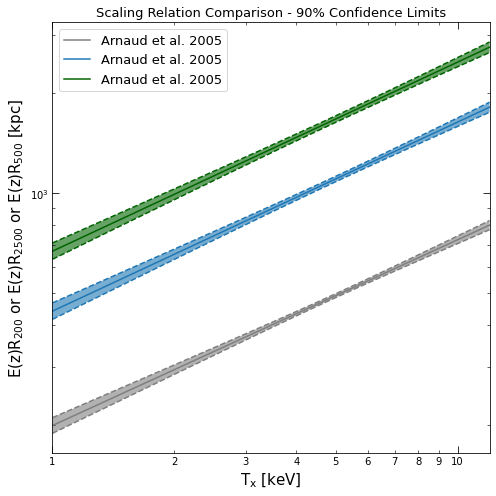

In [19]:
(arnaud_r2500 + arnaud_r500 + arnaud_r200).view(figsize=(7, 7))

### Step 2 - Iterate until convergence

Now that we have used the starting fixed aperture to measure a temperature and estimate a radius, we will iterate and repeat this process, using the new radius estimate to generate/fit a new set of spectra for each cluster, and then using the resulting new temperature measurement to estimate a radius value.

A cluster radius is considered to be converged (which is when it is accepted and will not change anymore) if the new radius estimate is within a certain percentage of the last estimate (the convergence fraction can be set by the user, and the default value is 0.1/10%). 

Convergence can only occur once a minimum number of iterations has taken place (the user can set this value, and the default is 3), and the iterative process will exit either when all clusters have 'accepted' radii, or when the maximum number of iterations is reached (again can be set by the user, the default is 10).

It is quite possible that spectral fitting will fail for some of the clusters during one of these iterations. If that is the case then a temperature estimate has not been produced and the pipeline cannot continue to analyse that particular cluster. Such clusters are removed from the XGA sample, though whatever progress they made through the iterations will still be recorded in the radii history dataframe (see step 4).

### Step 3 - Measure results for the final radii

Once the iterative process has concluded, hopefully (but not necessarily) with no clusters dropping out and all of the radii successfully converging, there is another call to the XGA `single_temp_apec` function. As some clusters may only have achieved radius convergence in the very last iteration, they may not yet have temperature/luminosity measurements for those radii. Calling `single_temp_apec` after the iterative process is over ensures that there are measurements in those cases.

Finally, if the user has indicated (through setting `core_excised=True` in the pipeline call) that they wish to also measure core-excised results (where spectra are generated in the [0.15-1]$R_{\Delta}$ region, and then fit), there will be another call to `single_temp_apec`. If the user sets `core_excised=True` when the scaling relation is for $R_{2500}$, there will be a warning shown at the beginning to ensure that they meant for this behaviour.

**Note** - Setting `core_excised=True` will provide core-excised results _in addition_ to global results, not instead of. 

### Step 4 - Record results and radius history

Once all spectral generation and fitting are complete, the final results (in the form of a Pandas dataframe) will be put together for the user. Not every entry in the input `sample_data` dataframe will necessarily be present in the output results dataframe; if a cluster was found to have no X-ray data by the ClusterSample declaration, then it will not be included, but objects that failed part way through the iterative process **will** be included (though with NaN entries for the measurements). 

A dataframe containing the history of the radii through the various iterative steps will also be produced. Again this will only contain entries for those clusters which have some X-ray data, but will contain clusters that failed part way through the iterative process. For those that failed part way through, all entries for after their failure will be NaN values. The final column in this dataframe indicates whether the radius is considered to be converged or not, as it is possible to have entries for all iteration steps and it still not be converged because it reached the iteration limit set by `max_iter`.

If the pipeline is being used interactively, the ClusterSample created for the analysis will be the first entry in the tuple returned by the pipeline function, the results dataframe will be the second entry, and the radius history dataframe the last. 

The user may instead (or additionally) choose to **write the results and radius history dataframes to csv**, by setting the `save_samp_results_path` and `save_rad_history_path` variables with the paths to save the files to.

## Demonstrating the pipeline

In this case we will use the pipeline interactively, and capture the returned ClusterSample, results dataframe, and radius history dataframe, as well as setting the variables necessary to write the results/radius history dataframes to disk. 

There are quite a few configuration options, but we will largely leave things on the default settings for this demonstration. To give you an idea of what you can change, take a look at the docstring of the function printed below (you can access this in Jupyter by hitting `shift+tab` while your caret is inside the function brackets, or you can look at it in the XGA API documentation entry for [luminosity_temperature_pipeline](../../xga.tools.rst#xga.tools.clusters.LT.luminosity_temperature_pipeline)):

In [38]:
print(luminosity_temperature_pipeline.__doc__)


     This is the XGA pipeline for measuring overdensity radii, and the temperatures and luminosities within the
     radii, for a sample of clusters. No knowledge of the overdensity radii of the clusters is required
     beforehand, only the position and redshift of the objects. A name is also required for each of them.

     The pipeline works by measuring a temperature from a spectrum generated with radius equal to the
     'start_aperture', and the using the radius temperature relation ('rad_temp_rel') to infer a value for the
     overdensity radius you are targeting. The cluster's overdensity radius is set equal to the new radius estimate
     and we repeat the process.

     A cluster radius measurement is accepted if the 'current' estimate of the radius is considered to be converged
     with the last estimate. For instance if 'convergence_frac' is set to 0.1, convergence occurs when a change of
     less than 10% from the last radius estimate is measured. The radii cannot be a

### Loading the example sample

In this case we use a subset of a sample of 150 clusters selected from SDSS, analysed by the XMM Cluster Survey (XCS), and that have been found to have well constrained temperature measurements ([Giles, et al. 2022](https://arxiv.org/abs/2202.11107)). The subset consists of 40 clusters, selected randomly. 

The sample file contains coordinates, which are derived from XCS X-ray centroid measurements using the XAPA source finder. It also contains redshift values, which come from the redMaPPer catalogue that the SDSSRM-XCS sample was selected from initially. The names in the sample combine an XCSSDSS prefix with the 'MEM_MATCH_ID' entry in the original SDSS redMaPPeR catalogue. XCS measurements of $R_{500}$ are present in the sample, though only to provide a point of comparison, **they are not used by the pipeline**. 

In [33]:
samp = pd.read_csv('lt_examp_samp.csv')
samp.info()
samp.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      40 non-null     object 
 1   ra        40 non-null     float64
 2   dec       40 non-null     float64
 3   redshift  40 non-null     float64
 4   xcs_r500  40 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.7+ KB


,name,ra,dec,redshift,xcs_r500
0,SDSSXCS-487,323.799200,-1.049468,0.333912,1103.195128
1,SDSSXCS-17923,350.470410,19.893604,0.314943,488.754689
2,SDSSXCS-5977,35.868932,-8.868981,0.167958,778.068206
3,SDSSXCS-890,126.489460,4.246014,0.234921,960.169165
4,SDSSXCS-30950,251.929730,34.936056,0.249875,556.325349
